In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

In [2]:
### IMPORT SPEKTRAL CLASSES ###

from spektral_utilities import *
from spektral_gcn import GraphConv

In [3]:
### READ DATA ###

df = pd.read_csv('sales_train.csv.zip')
df['date'] = pd.to_datetime(df['date'])

print(df.shape)
df.head()

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
### SWITCH DATA FROM VERTICAL TO HORIZONTAL FORMAT ###

unstaked_df = df.copy()
unstaked_df['id'] = df['item'].astype(str)+'_'+df['store'].astype(str)
unstaked_df.set_index(['id','date'], inplace=True)
unstaked_df.drop(['store','item'], axis=1, inplace=True)
unstaked_df = unstaked_df.astype(float).unstack()
unstaked_df.columns = unstaked_df.columns.get_level_values(1)

print(unstaked_df.shape)
unstaked_df.head()

(500, 1826)


date,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
id,,,,,,,,,,,,,,,,,,,,,
10_1,37.0,34.0,32.0,45.0,35.0,54.0,37.0,37.0,32.0,36.0,...,60.0,67.0,88.0,42.0,50.0,55.0,63.0,56.0,78.0,74.0
10_10,45.0,50.0,53.0,51.0,54.0,54.0,54.0,40.0,50.0,53.0,...,64.0,74.0,66.0,61.0,53.0,72.0,81.0,69.0,86.0,67.0
10_2,51.0,56.0,46.0,56.0,53.0,68.0,37.0,47.0,65.0,61.0,...,86.0,114.0,84.0,66.0,69.0,63.0,78.0,76.0,77.0,116.0
10_3,38.0,60.0,50.0,46.0,46.0,52.0,40.0,41.0,32.0,38.0,...,83.0,71.0,101.0,45.0,61.0,51.0,56.0,61.0,72.0,68.0
10_4,30.0,29.0,37.0,45.0,52.0,58.0,29.0,44.0,53.0,39.0,...,75.0,64.0,86.0,56.0,54.0,57.0,53.0,65.0,74.0,69.0


In [5]:
### UTILITY FUNCTIONS FOR FEATURE ENGINEERING ###

sequence_length = 14



def get_timespan(df, today, days):    
    df = df[pd.date_range(today - timedelta(days=days), 
            periods=days, freq='D')] # day - n_days <= dates < day    
    return df

def create_features(df, today, seq_len):
    
    all_sequence = get_timespan(df, today, seq_len).values
    
    group_store = all_sequence.reshape((-1, 10, seq_len))
    
    store_corr = np.stack([np.corrcoef(i) for i in group_store], axis=0)
    
    store_features = np.stack([
              group_store.mean(axis=2),
              group_store[:,:,int(seq_len/2):].mean(axis=2),
              group_store.std(axis=2),
              group_store[:,:,int(seq_len/2):].std(axis=2),
              skew(group_store, axis=2),
              kurtosis(group_store, axis=2),
              np.apply_along_axis(lambda x: np.polyfit(np.arange(0, seq_len), x, 1)[0], 2, group_store)
            ], axis=1)
    
    group_store = np.transpose(group_store, (0,2,1))
    store_features = np.transpose(store_features, (0,2,1))
    
    return group_store, store_corr, store_features

def create_label(df, today):
    
    y = df[today].values
    
    return y.reshape((-1, 10))

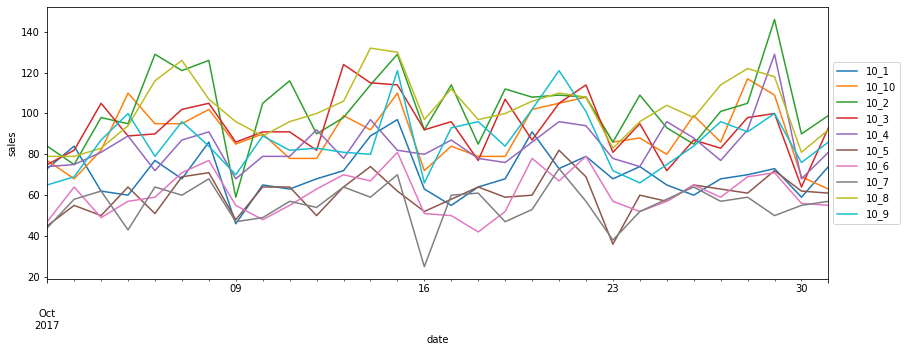

In [6]:
### PLOT A SEQUENCE OF SALES FOR ITEM 10 IN ALL STORES ###

sequence = get_timespan(unstaked_df, date(2017,11,1), 30)
sequence.head(10).T.plot(figsize=(14,5))
plt.ylabel('sales')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [7]:
### DEFINE TRAIN, VALID, TEST DATES ###

train_date = date(2013, 1, 1)
valid_date = date(2015, 1, 1)
test_date = date(2016, 1, 1)

In [8]:
### CREATE TRAIN FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(train_date+timedelta(days=sequence_length), valid_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_train_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_train_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_train_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_train = np.concatenate(y, axis=0).astype('float16')

print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, y_train.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 717/717 [00:39<00:00, 17.95it/s]


(35850, 14, 10) (35850, 10, 10) (35850, 10, 7) (35850, 10)


In [9]:
### CREATE VALID FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(valid_date+timedelta(days=sequence_length), test_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_valid_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_valid_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_valid_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_valid = np.concatenate(y, axis=0).astype('float16')

print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, y_valid.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:19<00:00, 17.78it/s]


(17600, 14, 10) (17600, 10, 10) (17600, 10, 7) (17600, 10)


In [10]:
### CREATE TEST FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(test_date+timedelta(days=sequence_length), date(2016,12,31))):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_test_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_test_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_test_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_test = np.concatenate(y, axis=0).astype('float16')

print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:19<00:00, 18.14it/s]


(17600, 14, 10) (17600, 10, 10) (17600, 10, 7) (17600, 10)


In [11]:
### SCALE SEQUENCES ###

scaler_seq = StandardScaler()
scaler_feat = StandardScaler()

X_train_seq = scaler_seq.fit_transform(X_train_seq.reshape(-1,10)).reshape(X_train_seq.shape)
X_valid_seq = scaler_seq.transform(X_valid_seq.reshape(-1,10)).reshape(X_valid_seq.shape)
X_test_seq = scaler_seq.transform(X_test_seq.reshape(-1,10)).reshape(X_test_seq.shape)

y_train = scaler_seq.transform(y_train)
y_valid = scaler_seq.transform(y_valid)
y_test = scaler_seq.transform(y_test)

X_train_feat = scaler_feat.fit_transform(X_train_feat.reshape(-1,10)).reshape(X_train_feat.shape)
X_valid_feat = scaler_feat.transform(X_valid_feat.reshape(-1,10)).reshape(X_valid_feat.shape)
X_test_feat = scaler_feat.transform(X_test_feat.reshape(-1,10)).reshape(X_test_feat.shape)

In [12]:
### OBTAIN LAPLACIANS FROM CORRELATIONS ###

X_train_lap = localpooling_filter(1 - np.abs(X_train_cor))
X_valid_lap = localpooling_filter(1 - np.abs(X_valid_cor))
X_test_lap = localpooling_filter(1 - np.abs(X_test_cor))

In [13]:
def get_model():

    opt = Adam(lr=0.001)

    inp_seq = Input((sequence_length, 10))
    inp_lap = Input((10, 10))
    inp_feat = Input((10, X_train_feat.shape[-1]))

    x = GraphConv(32, activation='relu')([inp_feat, inp_lap])
    x = GraphConv(16, activation='relu')([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(128, activation='relu', return_sequences=True)(inp_seq)
    xx = LSTM(32, activation='relu')(xx)

    x = Concatenate()([x,xx])
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    model.compile(optimizer=opt, loss='mse', 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [14]:
model = get_model()
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10, 7)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 10)]     0                                            
__________________________________________________________________________________________________
graph_conv (GraphConv)          (None, 10, 32)       256         input_3[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 14, 10)]     0                                        

In [15]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###


tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



pred_valid_all = np.zeros(y_valid.shape)
pred_test_all = np.zeros(y_test.shape)

for store in range(10):

    print('-------', 'store', store, '-------')
    
    es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

    model = get_model()
    model.fit([X_train_seq, X_train_lap, X_train_feat], y_train[:,store], epochs=100, batch_size=256, 
              validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], y_valid[:,store]), callbacks=[es], verbose=2)

    pred_valid_all[:,store] = model.predict([X_valid_seq, X_valid_lap, X_valid_feat]).ravel()
    pred_test_all[:,store] = model.predict([X_test_seq, X_test_lap, X_test_feat]).ravel()


pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
reverse_valid = scaler_seq.inverse_transform(y_valid)
pred_test_all = scaler_seq.inverse_transform(pred_test_all)
reverse_test = scaler_seq.inverse_transform(y_test)

------- store 0 -------
Epoch 1/100
141/141 - 9s - loss: 0.3333 - root_mean_squared_error: 0.5773 - val_loss: 0.6192 - val_root_mean_squared_error: 0.7869
Epoch 2/100
141/141 - 9s - loss: 0.2525 - root_mean_squared_error: 0.5025 - val_loss: 0.5271 - val_root_mean_squared_error: 0.7260
Epoch 3/100
141/141 - 9s - loss: 0.2389 - root_mean_squared_error: 0.4888 - val_loss: 0.4562 - val_root_mean_squared_error: 0.6754
Epoch 4/100
141/141 - 9s - loss: 0.2287 - root_mean_squared_error: 0.4783 - val_loss: 0.3028 - val_root_mean_squared_error: 0.5502
Epoch 5/100
141/141 - 9s - loss: 0.1975 - root_mean_squared_error: 0.4444 - val_loss: 0.5066 - val_root_mean_squared_error: 0.7117
Epoch 6/100
141/141 - 9s - loss: 0.1785 - root_mean_squared_error: 0.4225 - val_loss: 0.2615 - val_root_mean_squared_error: 0.5114
Epoch 7/100
141/141 - 9s - loss: 0.1689 - root_mean_squared_error: 0.4109 - val_loss: 0.2729 - val_root_mean_squared_error: 0.5224
Epoch 8/100
141/141 - 9s - loss: 0.1665 - root_mean_squared

Epoch 9/100
141/141 - 6s - loss: 0.1534 - root_mean_squared_error: 0.3916 - val_loss: 0.1560 - val_root_mean_squared_error: 0.3950
Epoch 10/100
141/141 - 6s - loss: 0.1533 - root_mean_squared_error: 0.3916 - val_loss: 0.1197 - val_root_mean_squared_error: 0.3459
Epoch 11/100
141/141 - 6s - loss: 0.1493 - root_mean_squared_error: 0.3863 - val_loss: 0.2063 - val_root_mean_squared_error: 0.4542
Epoch 12/100
141/141 - 6s - loss: 0.1469 - root_mean_squared_error: 0.3833 - val_loss: 0.1717 - val_root_mean_squared_error: 0.4144
Epoch 13/100
141/141 - 6s - loss: 0.1442 - root_mean_squared_error: 0.3797 - val_loss: 0.1560 - val_root_mean_squared_error: 0.3949
Epoch 14/100
141/141 - 6s - loss: 0.1433 - root_mean_squared_error: 0.3786 - val_loss: 0.1582 - val_root_mean_squared_error: 0.3977
Epoch 15/100
Restoring model weights from the end of the best epoch.
141/141 - 6s - loss: 0.1394 - root_mean_squared_error: 0.3734 - val_loss: 0.1345 - val_root_mean_squared_error: 0.3667
Epoch 00015: early st

Epoch 5/100
141/141 - 6s - loss: 0.2209 - root_mean_squared_error: 0.4700 - val_loss: 0.3674 - val_root_mean_squared_error: 0.6062
Epoch 6/100
141/141 - 7s - loss: 0.2128 - root_mean_squared_error: 0.4614 - val_loss: 0.1986 - val_root_mean_squared_error: 0.4456
Epoch 7/100
141/141 - 6s - loss: 0.2068 - root_mean_squared_error: 0.4547 - val_loss: 0.2227 - val_root_mean_squared_error: 0.4719
Epoch 8/100
141/141 - 6s - loss: 0.1977 - root_mean_squared_error: 0.4446 - val_loss: 0.2334 - val_root_mean_squared_error: 0.4831
Epoch 9/100
141/141 - 6s - loss: 0.1963 - root_mean_squared_error: 0.4430 - val_loss: 0.3211 - val_root_mean_squared_error: 0.5666
Epoch 10/100
141/141 - 6s - loss: 0.1916 - root_mean_squared_error: 0.4377 - val_loss: 0.1926 - val_root_mean_squared_error: 0.4388
Epoch 11/100
141/141 - 6s - loss: 0.1898 - root_mean_squared_error: 0.4357 - val_loss: 0.1996 - val_root_mean_squared_error: 0.4468
Epoch 12/100
141/141 - 6s - loss: 0.1891 - root_mean_squared_error: 0.4349 - val_

In [16]:
### RMSE ON TEST DATA ###

error = {}

for store in range(10):
    
    error[store] = np.sqrt(mean_squared_error(reverse_test[:,store], pred_test_all[:,store]))

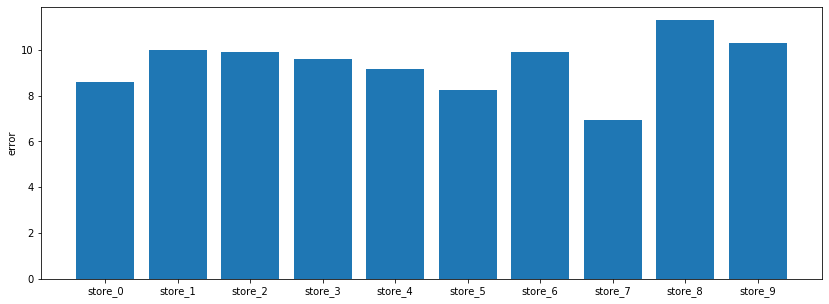

In [17]:
### PLOT RMSE ###

plt.figure(figsize=(14,5))
plt.bar(range(10), error.values())
plt.xticks(range(10), ['store_'+str(s) for s in range(10)])
plt.ylabel('error')
np.set_printoptions(False)

In [18]:
### UTILITY FUNCTION TO PLOT PREDICTION ###

def plot_predictions(y_true, y_pred, store, item):
    
    y_true = y_true.reshape(50,-1,10)
    y_pred = y_pred.reshape(50,-1,10)
    
    plt.plot(y_true[item,:,store], label='true')
    plt.plot(y_pred[item,:,store], label='prediction')
    plt.title(f"store: {store} item: {item}"); plt.legend()
    plt.ylabel('sales'); plt.xlabel('date')

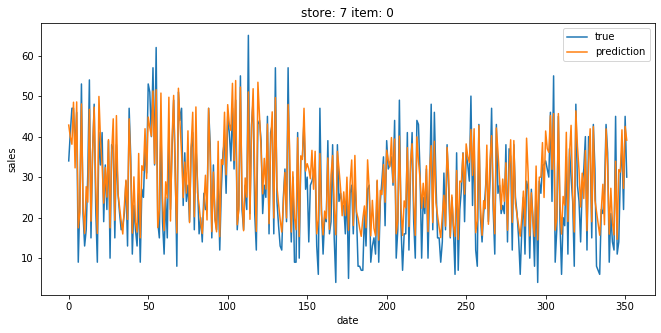

In [19]:
plt.figure(figsize=(11,5))
plot_predictions(reverse_test, pred_test_all, 7,0)